# Radial Basis Networks

Una forma distinta de lidiar con datos no linealmente separables es a partir de las Radial Basis Networks (RBN). Este tipo de redes aprovechan las llamadas funciones de base radial, las cuales son funciones cuyo valor depende de la distancia (con respecto a una métrica) con respecto a un punto dado. A continuación desarrollamos una red de este tipo para resolver el problema XOR.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from collections import Counter, defaultdict

### El problema XOR

Como hemos visto, el problema XOR no es linealmente separable. Hemos visto que una red FeedForward es capaz de resolver este problema. Las RBN también pueden resolverlo, pero su perspectiva difiere con respecto a las redes FeedForward.

In [2]:
#dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]])
#Clases XOR
Y = np.array([0,1,1,0])

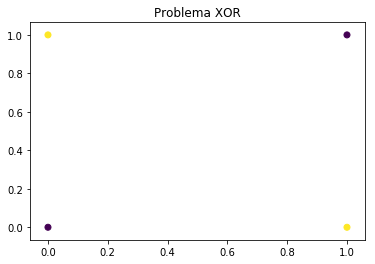

In [3]:
#Visualización
plt.scatter(X[:,0], X[:,1],c=Y)
plt.title('Problema XOR')
plt.show()

### Estimación de la capa oculta

Para estimar la capa oculta, a diferencia de las redes FeedForward, utilizaremos el método de $k$-means que  estimará los parámetros (la media) de una  distribución normal estándar. Así, la capa  oculta  puede verse en términos probabilísticos, lo que la hace más interpretable. 

Para estimar estos parámetros (media de la distribución) se buscará minimizar la varianza:

$$\hat{C} = \arg\min_{C} \frac{1}{2N}\sum_x \sum_{c_i\in C} ||x-c_i||^2$$

Donde $C= \{c_1,...,c_k\}$.

In [7]:
#Número de clúster
n_clusters= 4
#Inicialización de parámetros
C = np.random.random((n_clusters,X.shape[1]))
#Paro
stop = False

while stop == False:
    #Cálculo de distancias con respecto a c
    dists = np.array([np.linalg.norm(X-c, axis=1) for c in C])
    #Cluster más cercano
    clusts = np.argmin(dists,axis=0)
    
    #Clusterización de los datos
    clusters = defaultdict(list)
    for k,v in zip(clusts,X):
        clusters[k].append(v)

    #Actualización de C
    new_c = np.array([sum(vecs)/len(vecs) for clas, vecs in clusters.items()])
    
    #Criterio de paro
    if (C==new_c).all() == True:
        stop = True
    else:
        #Actualización de parámetros
        C = new_c    

In [8]:
print(C)

[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]


Una vez estimados los parámmetros, podemos calcular  la capa oculta a partir de la función:

$$h_i = exp[\frac{-||x-c_i||^2}{2}]$$

El resultado será la probabilidad de que $x$ pertenezca a ese cluster.

In [9]:
#Calculo de capa oculta para todos los datos
h = np.exp([-np.linalg.norm(x-C,axis=1)**2/2 for x in X])
print(h)

[[1.         0.60653066 0.60653066 0.36787944]
 [0.60653066 1.         0.36787944 0.60653066]
 [0.60653066 0.36787944 1.         0.60653066]
 [0.36787944 0.60653066 0.60653066 1.        ]]


Visualmente, estas medias son centroides o puntos en el espacio de los datos que determinan una probabilidad en base a la cercanía de un punto al centroido. Así, para este caso, podemos ver que, teniendo 4 unidades ocultas, cada media corresponde a cada uno de los puntos del problema XOR (lo que no siempre tiene porque ser así).

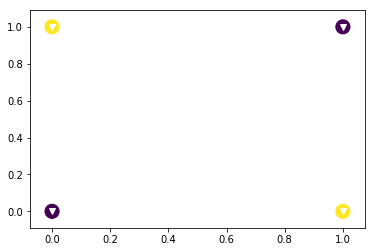

In [10]:
plt.plot(C[:,0], C[:,1], 'v', c='w')
plt.scatter(X[:,0], X[:,1],c=Y,s=200)
plt.show()

Las unidades ocultas pueden verse como distribuciones probabilísticas. Así cada unidad oculta determina una probabilidad. De la forma en que se han determinado los parámetros de esta distribución (por medio de $k$-means) las distribución resulta ser normal ($N(c_i,1)$). podemos visualizar estas distribuciones.

In [11]:
def plot_dist(mu):
    #Distribución normal
    a = np.linspace(-3,3,500)
    b = np.linspace(-3,3,500)
    A, B = np.meshgrid(a,b)
    pos = np.empty(A.shape + (2,))
    pos[:, :, 0] = A; pos[:, :, 1] = B
    rv = multivariate_normal(mu) #, np.dot(desv.T,desv))

    #Ploteo
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(A, B, rv.pdf(pos),cmap='viridis',linewidth=0)

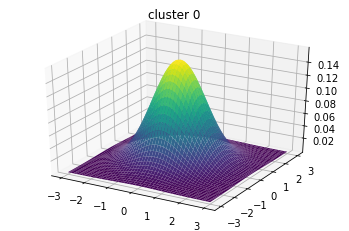

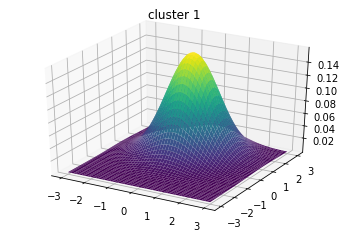

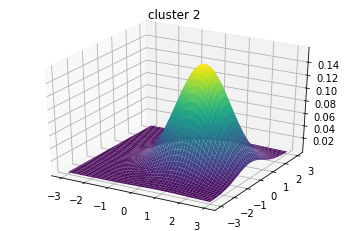

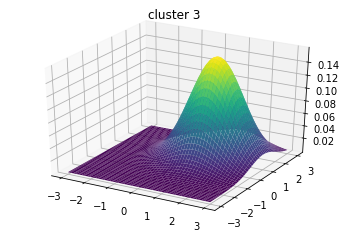

In [12]:
#Deviation
#stdev = [np.linalg.inv(np.linalg.norm(x-C,axis=1).reshape(2,2)) for x in X]

#Visualización de las unidades ocultas
for i in range(n_clusters):
    plot_dist(C[i])
    plt.title('cluster '+str(i))
    plt.show()

### Estimación de la capa de salida

La  capa de salida puede verse como un perceptrón simple; dado que la clasificación es binaria, tendremos una función de decisión dada por $$f(x) = \begin{cases} 0 & \text{ si } wh > 0 \\ 1 & \text{ si } wh \leq 0 \end{cases}$$

In [13]:
#Función de decisión
f = lambda x, theta: (np.dot(x,theta) >= 0).astype(np.int)

Así, estimaremos los parámetros del perceptrón hasta que converga a una solución (en este caso no usamos bias).

In [16]:
#Parámetros
w = np.ones(n_clusters)

#Núm. max de iteraciones
its = 100
#Learning rate
lr = 1.0


#Detenerse
stop = False
t = 0
while  stop == False:
    #FORWARD
    #Funcion de prediccion
    pred = f(h,w) 
    #Error
    err =  pred - Y
    
    #ACTUALIZACIÓN
    #Gradiente descendiente
    w -= lr*((h.T * err).T).sum(0)
    
    risk = ((pred - Y)**2).sum(0)
    
    print('Estado', t, '\t prediccion', risk, '\t', end=" ")
    print('parametros', np.round(w,3))
    
    t += 1
    #Criterio de paro
    if (pred - Y).sum(0) == 0 or t > its: 
        stop = True

Estado 0 	 prediccion 2 	 parametros [-0.368 -0.213 -0.213 -0.368]
Estado 1 	 prediccion 2 	 parametros [0.845 1.155 1.155 0.845]
Estado 2 	 prediccion 2 	 parametros [-0.523 -0.058 -0.058 -0.523]
Estado 3 	 prediccion 2 	 parametros [0.69 1.31 1.31 0.69]
Estado 4 	 prediccion 2 	 parametros [-0.678  0.097  0.097 -0.678]
Estado 5 	 prediccion 2 	 parametros [0.536 1.464 1.464 0.536]
Estado 6 	 prediccion 2 	 parametros [-0.832  0.251  0.251 -0.832]
Estado 7 	 prediccion 2 	 parametros [0.381 1.619 1.619 0.381]
Estado 8 	 prediccion 2 	 parametros [-0.987  0.406  0.406 -0.987]
Estado 9 	 prediccion 2 	 parametros [0.226 1.774 1.774 0.226]
Estado 10 	 prediccion 2 	 parametros [-1.142  0.561  0.561 -1.142]
Estado 11 	 prediccion 2 	 parametros [0.071 1.929 1.929 0.071]
Estado 12 	 prediccion 2 	 parametros [-1.297  0.716  0.716 -1.297]
Estado 13 	 prediccion 2 	 parametros [-0.084  2.084  2.084 -0.084]
Estado 14 	 prediccion 2 	 parametros [-1.452  0.871  0.871 -1.452]
Estado 15 	 predic

Vemos que, en efecto, se ha encontrado una solución. En general, una solución para el problema XOR a partir de un RBN con 4 unidades ocultas es de la forma: $w^T = \begin{pmatrix} -1 & 1 & 1 & - 1 \end{pmatrix}$; de esta forma, una familia de soluciones es $\lambda \begin{pmatrix} -1 & 1 & 1 & - 1 \end{pmatrix}$ con $\lambda \in \mathbb{R}$. 

En este caso, hemos tenido una solución distinta, de la forma $ \begin{pmatrix} -a & b & b & - a \end{pmatrix}$, con $a,b \in \mathbb{R}$, que si bien no es como las que hemos propuesto, notamos que  $a$ tiene un valor muy cercano a $b$. 

Lo que esta solución nos señala es que, dado que las medias de las unidades ocultas están centradas en cada uno de los puntos de los datos, los puntos cercanos a cualquier dato de la clase 0 tendrán pesos negativos (de tal forma que la decisión sea 0), mientras que los puntos cercanos a los datos de la clase 1 tendrán valores positivos (así, la decisión será la clase 1).

## Aplicación de RBN a un otro de clasificación

Podemos observar cómo se comportan las RBN en un problema con un mayor número de datos y de variables. Para  esto, tomaremos el problema de clasificar una planta por su clase de iris.

#### Preparación de los datos

Estos  datos tienen tres clases, de las cuales sólo utilizaremos 2. Cada vector tiene 4 dimensiones. A continuación cargamos los dato: vectores de entrada y clases. Asimismo, dividiremos los datos en entrenamiento y evaluación.

In [37]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

#Cargar el dataset
data = load_iris()

#Utilizaremos los primeros 100 datos
X = data.data[:100]
Y = data.target[:100]

#División datos train y test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

#Tamaño de los datos
m,n = X.shape

print(X_train.shape, Y_train.shape)

(70, 4) (70,)


Una descripción del dataset se imprime a continuación.

In [38]:
print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

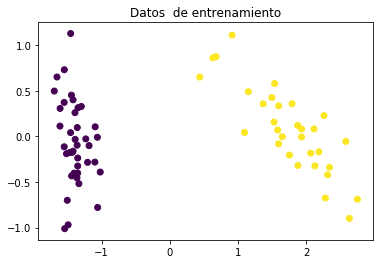

In [39]:
#Reducción a 2 dimensiones
RedX = PCA(2).fit_transform(X_train)

#Visualización de los ejemplos en R2
plt.scatter(RedX[:,0], RedX[:,1], c=Y_train)
plt.title('Datos  de entrenamiento')
plt.show()

### Capa oculta: estimación de medias

De igual forma que hicimos con el problema XOR, ahora estimaremos las medias. Para simplificar el proceso, esta vez utilizaremos la paquetería de KMeans  de SKlearn para obtener estos parámetros:

In [42]:
#Número de unidades
c = 4

#Obtención de parámetros por k-means
data = KMeans(n_clusters=c).fit(X)

#Conjunto de medias
C = data.cluster_centers_

print(C)

[[5.53333333 2.60416667 3.88333333 1.18333333]
 [5.24285714 3.66785714 1.5        0.28214286]
 [6.30769231 2.92307692 4.60769231 1.45769231]
 [4.70454545 3.12272727 1.41363636 0.2       ]]


Al igual que en el caso anterior, podemos ver cómo se distribuyen las medias en el espacio de los datos.

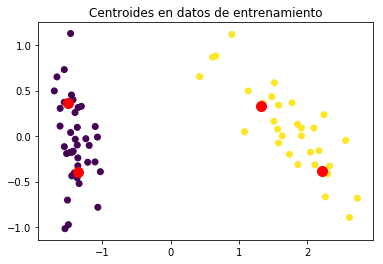

In [49]:
#Reducción a 2 dimensiones
R = PCA(2).fit_transform(np.concatenate((X_train,C)))

#Plotep
plt.scatter(R[:-c][:,0], R[:-c][:,1], c=Y_train)
plt.scatter(R[-c:][:,0], R[-c:][:,1], c='r', s=100)
plt.title('Centroides en datos de entrenamiento')
plt.show()

Ahora determinaremos la capa oculta por medio del cálculo de la probabilidad.

In [52]:
#Calculo de capa oculta para todos los datos
h = np.exp([-np.linalg.norm(x-C,axis=1)**2/2 for x in X_train])
print(h[:10])

[[2.06076685e-02 6.89880252e-01 8.30462232e-04 9.90592055e-01]
 [8.67180027e-01 1.23544712e-02 7.37925268e-01 7.55982661e-03]
 [6.60334549e-01 2.52728910e-02 1.35430412e-01 4.19884134e-02]
 [1.92304815e-02 9.94492264e-01 1.61358424e-03 7.06357146e-01]
 [9.88804461e-01 1.90599536e-02 5.19807183e-01 1.67255780e-02]
 [9.46476932e-01 2.97641232e-02 3.75430485e-01 2.98589497e-02]
 [7.82045768e-01 8.02235741e-03 8.43608657e-01 4.30061203e-03]
 [9.38622397e-01 1.25367069e-02 7.16391763e-01 8.55862172e-03]
 [1.46679269e-02 9.31906343e-01 1.16630725e-03 6.74355450e-01]
 [6.97961026e-01 5.56710504e-03 9.36284591e-01 2.70259356e-03]]


### Estimación del Perceptrón para los datos Iris

El perceptrón es un algoritmo de aprendizaje estadístico que busca estimar las clases de un conjunto de datos a partir de la función de decisión:

$$f(x; \theta) = \begin{cases} 1 & \text{ si } wx + b \geq 0 \\ 0 & \text{ si } wx + b < 0\end{cases}$$

Aquí $x$ es un vector de entrada. La función f depende de $\theta = {w,b}$ que representa los parámetros o los pesos de la red: $w$ contienen los pesos de las conexiones y $b$ es el bias. Definimos esta función a continuación:

In [53]:
#Función de decisión
f = lambda x, theta: (np.dot(x,theta) >= 0).astype(np.int)

Ahora entrenamos los parámetros  del perceptrón a partir de la capa oculta estimada con los centroides y la RBN.

In [65]:
#Parámetros
w = np.ones(n)

#Núm. max de iteraciones
its = 100
#Learning rate
lr = 0.01

In [66]:
#Detenerse
stop = False
t = 0
while  stop == False:
    #FORWARD
    #Funcion de prediccion
    pred = f(h,w) 
    #Error
    err =  pred - Y_train
    
    #ACTUALIZACIÓN
    #Gradiente descendiente
    w -= lr*((h.T * err).T).sum(0)
    
    risk = ((pred - Y_train)**2).sum(0)
    
    print('Estado', t, '\t prediccion', risk, '\t', end=" ")
    print('parametros', np.round(w,3))
    
    t += 1
    #Criterio de paro
    if (pred - Y_train).sum(0) == 0 or t > its: 
        stop = True

Estado 0 	 prediccion 39 	 parametros [0.991 0.67  0.999 0.683]
Estado 1 	 prediccion 39 	 parametros [0.983 0.341 0.999 0.367]
Estado 2 	 prediccion 39 	 parametros [0.974 0.011 0.998 0.05 ]
Estado 3 	 prediccion 39 	 parametros [ 0.965 -0.318  0.998 -0.267]
Estado 4 	 prediccion 0 	 parametros [ 0.965 -0.318  0.998 -0.267]


Podemos ver que  se converge  a una solución para los datos de entrenamiento. Esta clasificación estimada se visualiza a continuación.

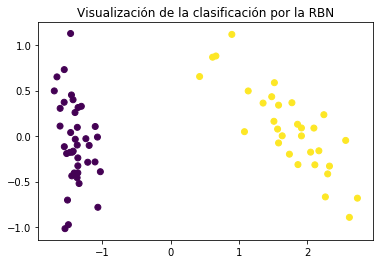

In [67]:
plt.scatter(R[:-c][:,0], R[:-c][:,1], c=f(h,w))
plt.title('Visualización de la clasificación por la RBN')
plt.show()

### Evaluación

Por último, podremos estimar qué tanto generaliza el modelo estimado por la RBN. Así, utilizaremos el dataset de evaluación (test) para ver qué  tan bien lo hace en datos que no ha estimado. Entonces, aplicaremos la RBN en los datos de evaluación:

In [69]:
#Calculo de capa oculta para todos los datos de evaluación
h_test = np.exp([-np.linalg.norm(x-C,axis=1)**2/2 for x in X_test])
print(h_test[:10])

[[2.82236846e-01 4.71902933e-04 8.61644314e-01 1.66374271e-04]
 [1.79977473e-02 7.09875401e-01 7.42241572e-04 9.82966978e-01]
 [1.11971946e-02 9.35908798e-01 9.88904571e-04 5.65320998e-01]
 [3.80410190e-03 7.13688509e-01 1.25170244e-04 8.14723062e-01]
 [2.90493643e-02 9.35908798e-01 3.42780283e-03 5.46125200e-01]
 [2.60668206e-02 7.99810782e-01 1.32516220e-03 9.77175665e-01]
 [4.99571194e-03 4.65755534e-01 1.12563883e-04 8.66283213e-01]
 [9.22723785e-01 1.41048405e-02 6.78836986e-01 9.87613244e-03]
 [3.82730058e-01 2.35158475e-03 8.90621452e-01 7.69044617e-04]
 [5.98741488e-01 4.50616566e-03 9.37726137e-01 1.96427060e-03]]


Podemos evaluar a partir del error cuadrático. En este caso, vemos que el modelo, para estos datos,  ha sido apropiado.

In [74]:
print(np.linalg.norm(f(h_test,w)-Y_test)**2)

0.0


Podemos visualizar cómo se comportan los datos de evaluación con respecto a los centroides.

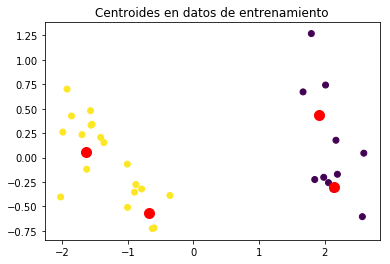

In [77]:
#Reducción a 2 dimensiones
R_eval = PCA(2).fit_transform(np.concatenate((X_test,C)))

#Plotep
plt.scatter(R_eval[:-c][:,0], R_eval[:-c][:,1], c=Y_test)
plt.scatter(R_eval[-c:][:,0], R_eval[-c:][:,1], c='r', s=100)
plt.title('Centroides en datos de entrenamiento')
plt.show()

Podemos observar que, en efecto, los centroides se acoplan bien a los grupos. De esta forma, la decisión se puede hacer adecuadamente, pues los datos de cada clase enstán cercanos a la media o centroide que los representa.